# Nearest Neighbors

## 1.Environment Setup

In [ ]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán giữa các lần chạy
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"Seed: {SEED}")

Seed: 42


## 2.Data Processing

In [ ]:
# https://drive.google.com/file/d/1T6AWCoyeC2MqGvmqZPPcA4ni5Md1k0sI/view?usp=sharing
!gdown 1T6AWCoyeC2MqGvmqZPPcA4ni5Md1k0sI

Downloading...
From: https://drive.google.com/uc?id=1T6AWCoyeC2MqGvmqZPPcA4ni5Md1k0sI
To: /content/dataset.zip
100% 21.1k/21.1k [00:00<00:00, 38.0MB/s]


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: splits/
  inflating: splits/fe_train.csv     
  inflating: splits/raw_test.csv     
  inflating: splits/raw_val.csv      
  inflating: splits/fe_test.csv      
  inflating: splits/fe_val.csv       
  inflating: splits/fe_feature_names.json  
  inflating: splits/raw_train.csv    


In [ ]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)

    return X, y

### 2.1 Original Dataset

In [ ]:
X_train, y_train = read_csv('splits/raw_train.csv')

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0,1
1,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0,0
3,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0,0
4,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0,1


,count
target,
0,131
1,111


Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)


In [ ]:
X_val, y_val = read_csv('splits/raw_val.csv')


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0,0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0,1
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,0
3,0.941197,0.229802,0.040979,0.973394,-0.891627,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.495681,0.229802,-0.300333,0.487519,-0.445445,1.0,1.000000,0.0,0.0,0.0,0.5,0.0,1.0,0


,count
target,
0,16
1,14


Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)


In [ ]:
X_test, y_test = read_csv('splits/raw_test.csv')

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.384303,-0.168240,-0.641646,-0.837597,1.071575,1.0,1.000000,0.0,1.0,1.0,0.5,1.0,1.0,1
1,-2.288787,-0.736870,-1.286348,1.061736,-0.891627,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.829818,-0.054513,-0.357219,-0.175039,0.714629,1.0,0.666667,0.0,0.0,0.0,0.5,1.0,1.0,0
3,-0.395349,-0.054513,0.116827,-0.042528,-0.445445,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-1.397757,-0.623144,-0.186562,1.945146,-0.177735,1.0,0.666667,1.0,0.0,0.0,1.0,0.0,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)


### 2.2 Feature Engineering Dataset

In [ ]:
X_train_fe, y_train_fe = read_csv('splits/fe_train.csv')

,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
3,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
4,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


,count
target,
0,131
1,111


Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)


In [ ]:
X_val_fe, y_val_fe = read_csv('splits/fe_val.csv')

,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,1.0,0.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.262410,1.0,0.089984,0.628019,0.0,0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.250048,0.0,1.368307,1.0,-1.809349,-1.592443,1.0,1
2,0.0,1.0,0.0,1.0,0.0,1.0,0.536156,1.0,-0.338257,0.0,0.664201,0.235034,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.040979,0.0,0.973394,-0.161823,0.0,0
4,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,-0.300333,1.0,0.487519,-0.163464,1.0,0


,count
target,
0,16
1,14


Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)


In [ ]:
X_test_fe, y_test_fe = read_csv('splits/fe_test.csv')

,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,0.0,1.0,0.0,1.071575,0.0,-0.641646,1.0,-0.837597,-0.736915,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,-1.286348,0.0,1.061736,2.749978,1.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.714629,0.0,-0.357219,1.0,-0.175039,-0.619566,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.445445,1.0,0.116827,0.0,-0.042528,0.071622,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,-0.177735,0.0,-0.186562,0.0,1.945146,2.141882,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)


## 3.K-Nearest Neighbors (KNN)

In [ ]:
def find_optimal_k(X_train, y_train,
                   k_range=range(1, 21), cv_splits=5):
    # Tạo bộ chia dữ liệu cross-validation
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    k_scores = []

    # Đánh giá bằng cross-validation trên tập train
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv_score = cross_val_score(
            knn, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1)
        k_scores.append(cv_score.mean())

    # Vẽ biểu đồ chọn k theo CV
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), k_scores, 'bo-')
    plt.title(f'Chọn K tối ưu cho KNN (CV={cv_splits}-fold)')
    plt.xlabel('Giá trị K')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    # K tối ưu theo CV
    optimal_k = list(k_range)[int(np.argmax(k_scores))]
    print(f"K tối ưu (CV): {optimal_k}")
    return optimal_k

def evaluate_val(X_train, y_train, X_val, y_val, optimal_k):
    # Huấn luyện KNN với k tối ưu
    print(f"Huấn luyện KNN với k tối ưu: {optimal_k}")
    knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
    knn_model.fit(X_train, y_train)

    # Dự đoán và đánh giá trên tập val
    knn_pred = knn_model.predict(X_val)
    knn_accuracy = accuracy_score(y_val, knn_pred)
    print(f"\nĐộ chính xác KNN trên tập validation: {knn_accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_val, knn_pred))
    return knn_model, knn_accuracy

def evaluate_test(knn_model, X_test, y_test):
    # Dự đoán và đánh giá trên tập test
    knn_test_pred = knn_model.predict(X_test)
    knn_test_accuracy = accuracy_score(y_test, knn_test_pred)
    print(f"\nĐộ chính xác KNN trên tập test: {knn_test_accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, knn_test_pred))
    return knn_test_accuracy


### 3.1 KNN on Original Dataset

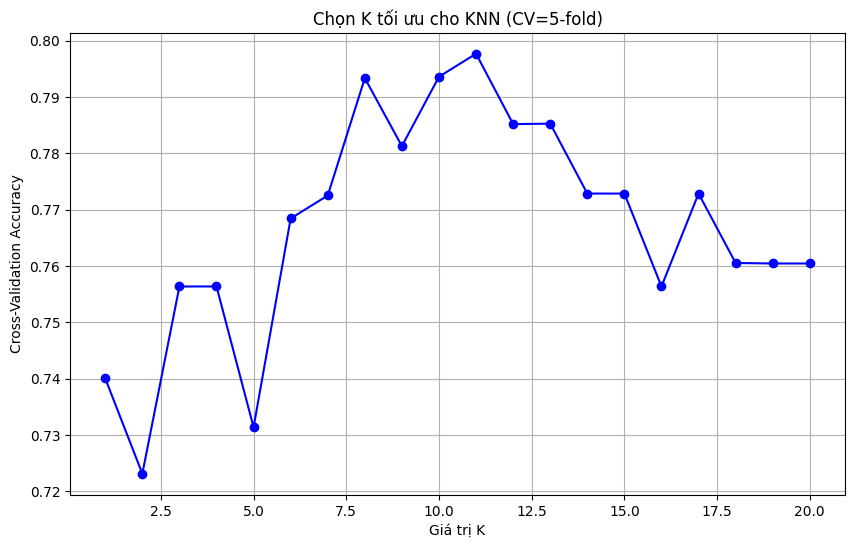

K tối ưu (CV): 11
Huấn luyện KNN với k tối ưu: 11

Độ chính xác KNN trên tập validation: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.87      0.93      0.90        14

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


Độ chính xác KNN trên tập test: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.85      0.79      0.81        14

    accuracy                           0.84        31
   macro avg       0.84      0.83      0.84        31
weighted avg       0.84      0.84      0.84        31



In [ ]:
k_optimal = find_optimal_k(X_train, y_train)
model, accuracy = evaluate_val(X_train, y_train, X_val, y_val, k_optimal)
test_accuracy = evaluate_test(model, X_test, y_test)

### 3.2 KNN on Feature Engineering Dataset

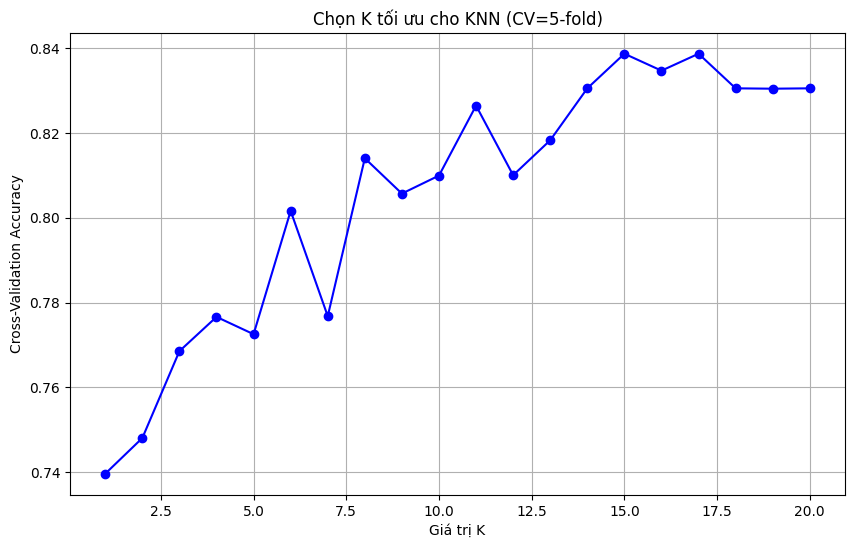

K tối ưu (CV): 15
Huấn luyện KNN với k tối ưu: 15

Độ chính xác KNN trên tập validation: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.87      0.93      0.90        14

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


Độ chính xác KNN trên tập test: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.76      0.93      0.84        14

    accuracy                           0.84        31
   macro avg       0.85      0.85      0.84        31
weighted avg       0.85      0.84      0.84        31



In [ ]:
k_optimal = find_optimal_k(X_train_fe, y_train_fe)
model_fe, accuracy_fe = evaluate_val(
    X_train_fe, y_train_fe,
    X_val_fe, y_val_fe,
    k_optimal
)
test_accuracy_fe = evaluate_test(model_fe, X_test_fe, y_test_fe)


## 4.Result Visualization

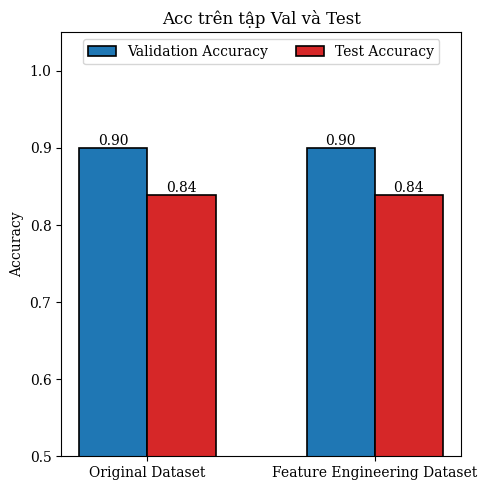

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Serif'

labels = ['Original Dataset', 'Feature Engineering Dataset']
val_accs  = [accuracy, accuracy_fe]
test_accs = [test_accuracy, test_accuracy_fe]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Acc trên tập Val và Test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()
